In [1]:
import numpy as np
import pandas as pd
import plotly 

# import matplotlib.pyplot as plt
# import matplotlib as mpl

import plotly.tools as tls 
import plotly.plotly as py  
import plotly.graph_objs as go
from plotly.graph_objs import *
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

from terminal_optimization import hydrogen_objects
from terminal_optimization import hydrogen_defaults
from terminal_optimization import hydrogen_system

plotly.tools.set_credentials_file(username='stephh', api_key='aYheUBjQH0kyWL5yo9E6')

# 0. Prepare inputs

In [2]:
startyear = 2019
lifecycle = 10

## 0.1 Generate demand forecast scenario

In [3]:
years = list(range(startyear, startyear+lifecycle))

demand = []
for year in years:
    if year < 2024:
        demand.append(1_000_000)
    else:
        demand.append(5_000_000)

scenario_data={'year': years, 'volume': demand}

# instantiate a commodity objects
lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)
lhydrogen.scenario_data = pd.DataFrame(data=scenario_data)

# Ammonia
hydrogen_defaults.commodity_ammonia_data['historic_data'] = []
hydrogen_defaults.commodity_ammonia_data['scenario_data'] = []
ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_ammonia_data)

# MCH
hydrogen_defaults.commodity_MCH_data['historic_data'] = []
hydrogen_defaults.commodity_MCH_data['scenario_data'] = []
MCH = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_MCH_data)

# combine
demand = [lhydrogen, ammonia, MCH]

# plot scenarios 
if False:
    lhydrogen.plot_demand()
    ammonia.plot_demand()
    MCH.plot_demand()

## 0.2 Generate vessels

In [4]:
# instantiate vessels
Smallhydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.smallhydrogen_data)
Largehydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.largehydrogen_data)
Smallammonia = hydrogen_objects.Vessel(**hydrogen_defaults.smallammonia_data)
Largeammonia = hydrogen_objects.Vessel(**hydrogen_defaults.largeammonia_data)
Handysize = hydrogen_objects.Vessel(**hydrogen_defaults.handysize_data)
Panamax = hydrogen_objects.Vessel(**hydrogen_defaults.panamax_data)
VLCC = hydrogen_objects.Vessel(**hydrogen_defaults.vlcc_data)


vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

# 1. Instatiate terminal system

In [5]:
Terminal = hydrogen_system.System(startyear = startyear, 
                         lifecycle = lifecycle, 
                         elements = demand + vessels, 
                         operational_hours = 5840,   # example Wijnand
                         debug=True)

# 2. Start simulation
Develop terminal given the throughput scenario and investment triggers implemented

In [6]:
Terminal.simulate()


Simulate year: 2019
  Total vessel calls: 0
     Small Hydrogen  calls: 0
     Large Hydrogen calls: 0
     Small ammonia calls: 0
     Large ammonia calls: 0
     Handysize calls: 0
     Panamax calls: 0
     VLCC calls: 0
  Total cargo volume: 0.0
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online (@ start of year): inf
     Unloading occupancy planned (@ start of year): inf
     Unloading occupancy online (@ start of year): inf
     waiting time factor (@ start of year): inf
     waiting time occupancy (@ start of year): nan
     throughput online 0
     throughput planned 0
  *** add Berth to elements
     Berth occupancy planned (after adding berth):

c:\users\stephanie lanphen\documents\terminal-optimization\src\terminal_optimization\hydrogen_system.py:1215: RuntimeWarning:

invalid value encountered in double_scalars




  *** add station to elements
  *** add Hinter Pipeline to elements
     a total of 0 ton of pipeline hinterland service capacity is online; 4000 ton total planned

Simulate year: 2020
  Total vessel calls: 0
     Small Hydrogen  calls: 0
     Large Hydrogen calls: 0
     Small ammonia calls: 0
     Large ammonia calls: 0
     Handysize calls: 0
     Panamax calls: 0
     VLCC calls: 0
  Total cargo volume: 0.0
     a total of 1 Berth_01 is online; 1 total planned
     a total of 0 Jetty_01 is online; 1 total planned
     a total of 0 jetty_pipeline_01 is online; 1 total planned
     a total of 0 HTank_01 is online; 8 total planned
     a total of 0 H2retrieval_LH2_01 is online; 3 total planned
     a total of 0 hinterland_pipeline_01 is online; 1 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): 0.1202054794520548
     Berth occupancy online (@ start of year): inf
     Unloading occupancy planned (@ start of year): 0.0
     Unloading occupancy online (@

     a total of 44000 ton of HydrogenTank storage capacity is online; 84000 ton total planned
  *** add storage to elements
     a total of 44000 ton of HydrogenTank storage capacity is online; 88000 ton total planned
  *** add storage to elements
     a total of 44000 ton of HydrogenTank storage capacity is online; 92000 ton total planned
  *** add storage to elements
     a total of 44000 ton of HydrogenTank storage capacity is online; 96000 ton total planned
     Plant occupancy planned (@ start of year): 2.2831050228310503
     Plant occupancy online (@ start of year): 0.4761904761904761
  *** add h2retrieval to elements
     a total of 2190000 ton of h2retrieval capacity is online; 2920000 ton total planned
  *** add h2retrieval to elements
     a total of 2190000 ton of h2retrieval capacity is online; 3650000 ton total planned
  *** add h2retrieval to elements
     a total of 2190000 ton of h2retrieval capacity is online; 4380000 ton total planned
  *** add h2retrieval to element

     Revenues: 0
     Revenues: 0
     Revenues: 1000000000
     Revenues: 1000000000
     Revenues: 1000000000
     Revenues: 1042857142
     Revenues: 2190000000
     Revenues: 5000000000
     Revenues: 5000000000
     Revenues: 5000000000
PV: [-3.54360000e+07 -4.87536402e+09 -5.16410219e+09 -4.42764523e+09
 -3.77917657e+09 -6.67681420e+09 -1.26928003e+10 -1.20844588e+10
 -1.00432908e+10 -3.37515170e+09]
NPV: -63154239777.47899


## Report all elements

In [7]:
if False: 
    for element in Terminal.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__)

In [8]:
# Terminal.add_cashflow_elements()

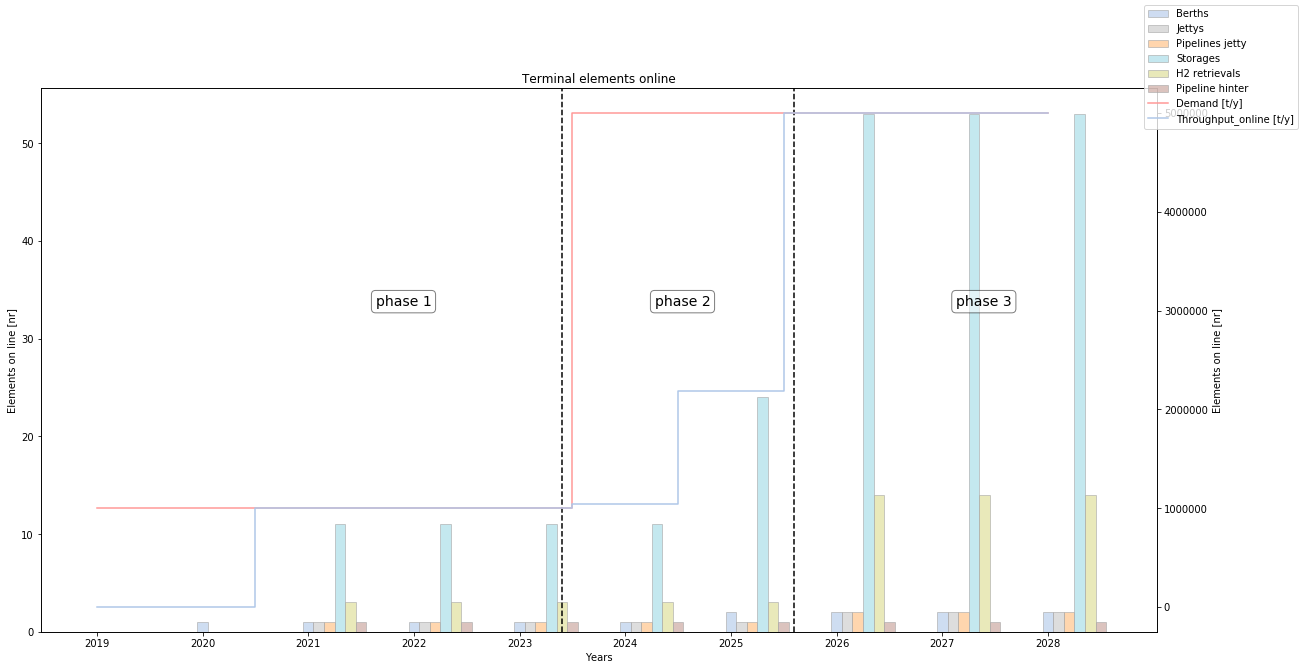

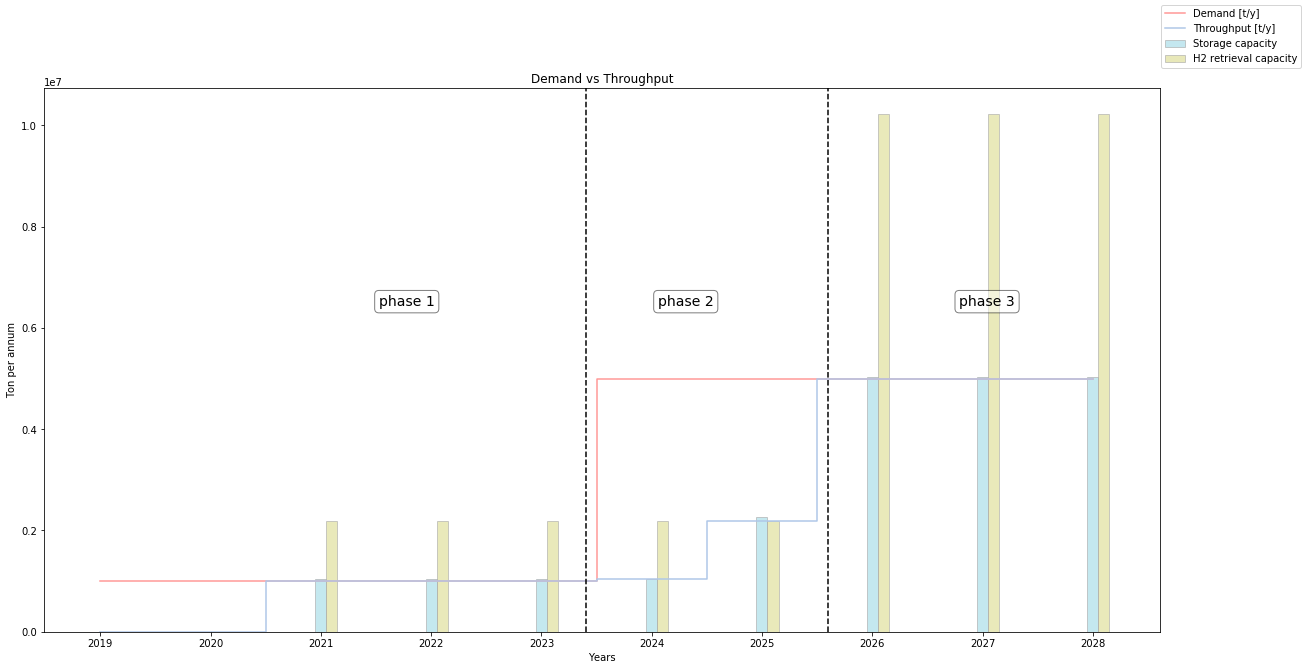

In [9]:
Terminal.terminal_elements_plot()
Terminal.demand_terminal_plot()

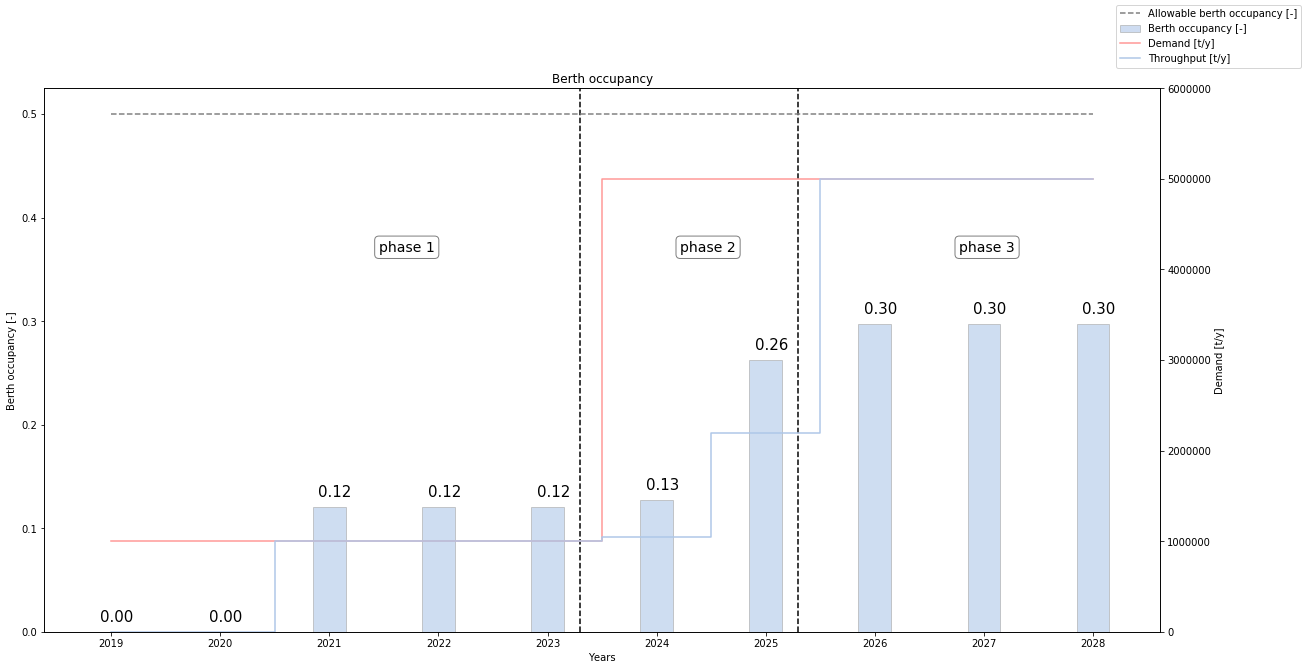

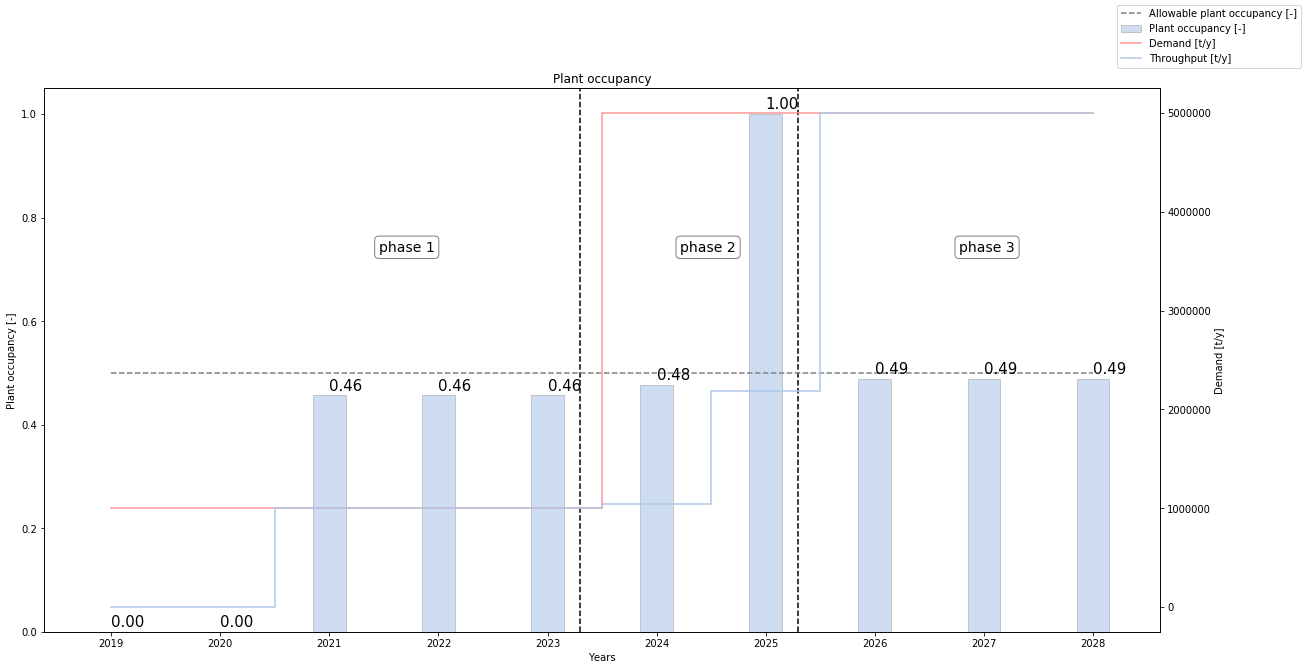

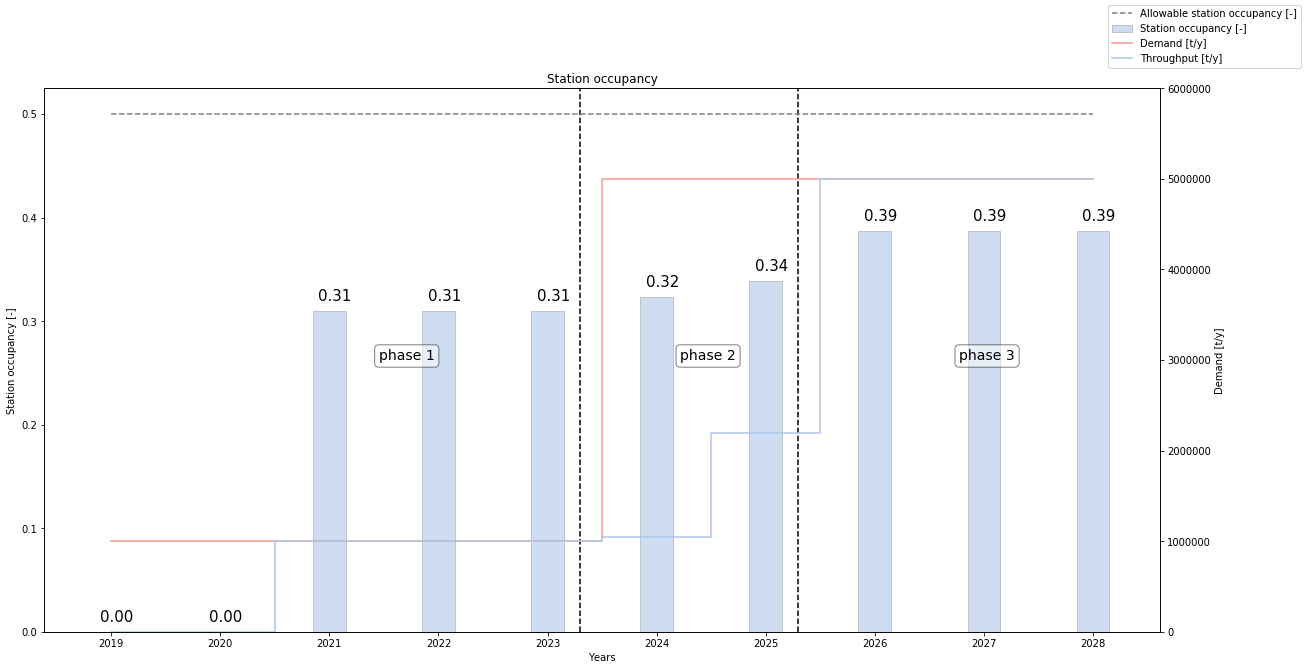

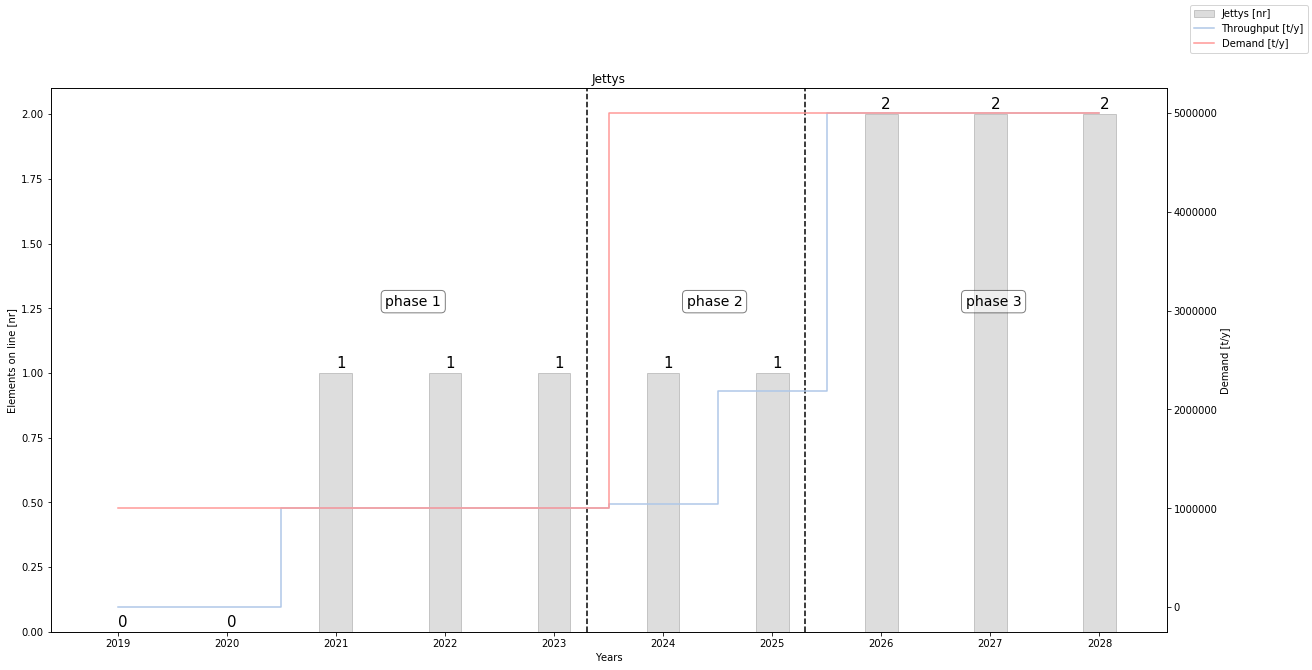

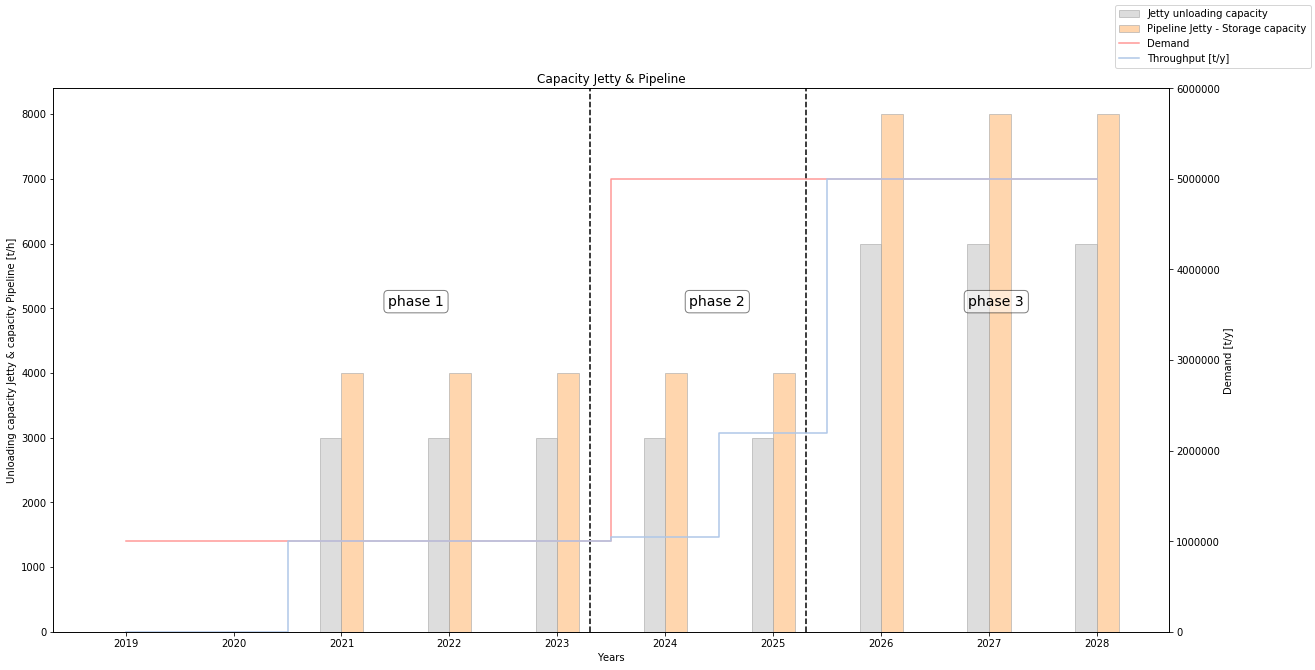

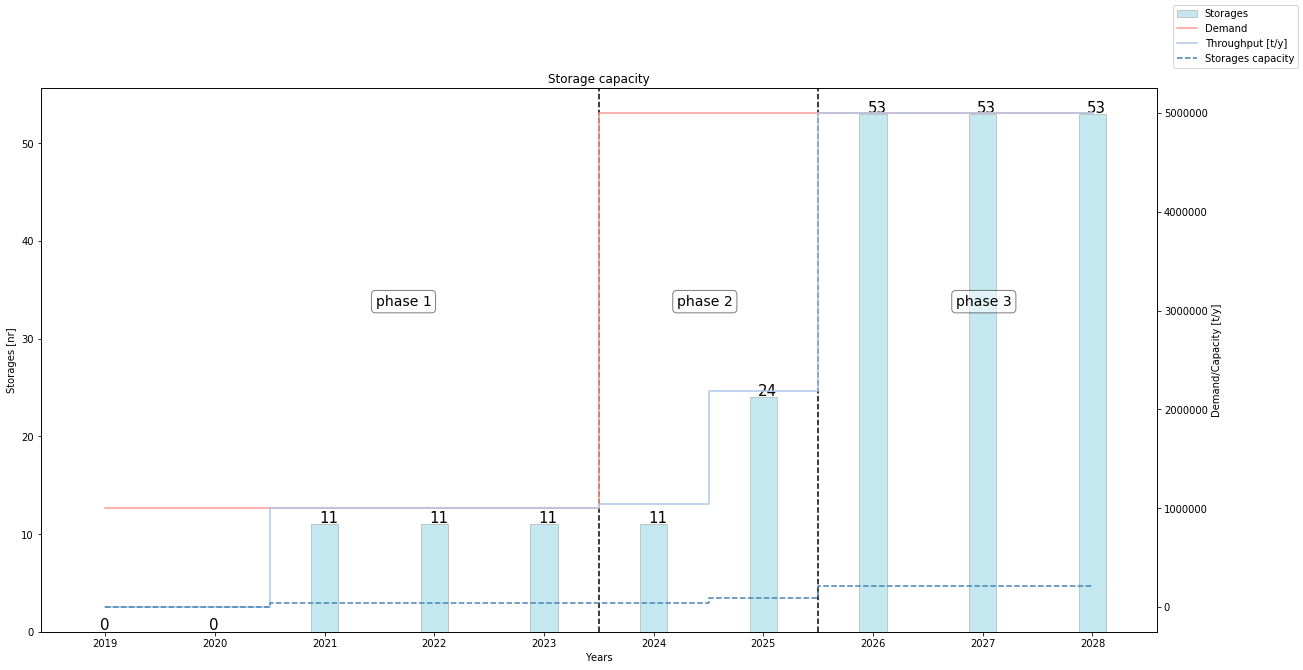

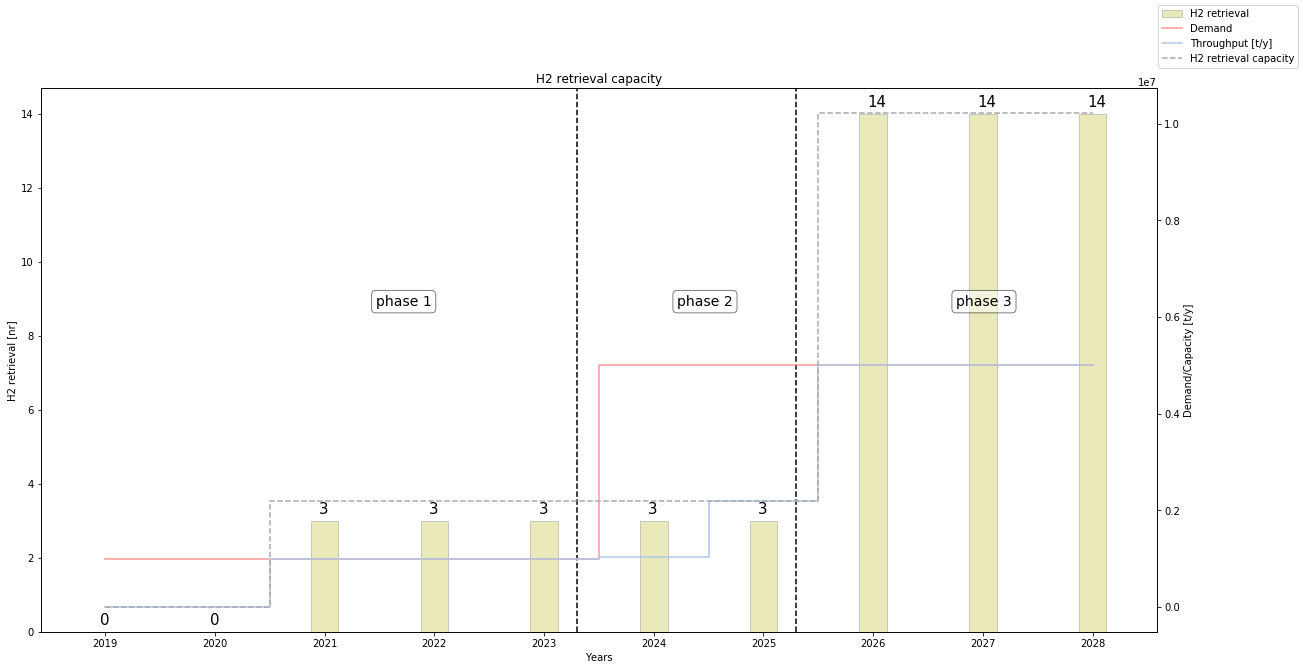

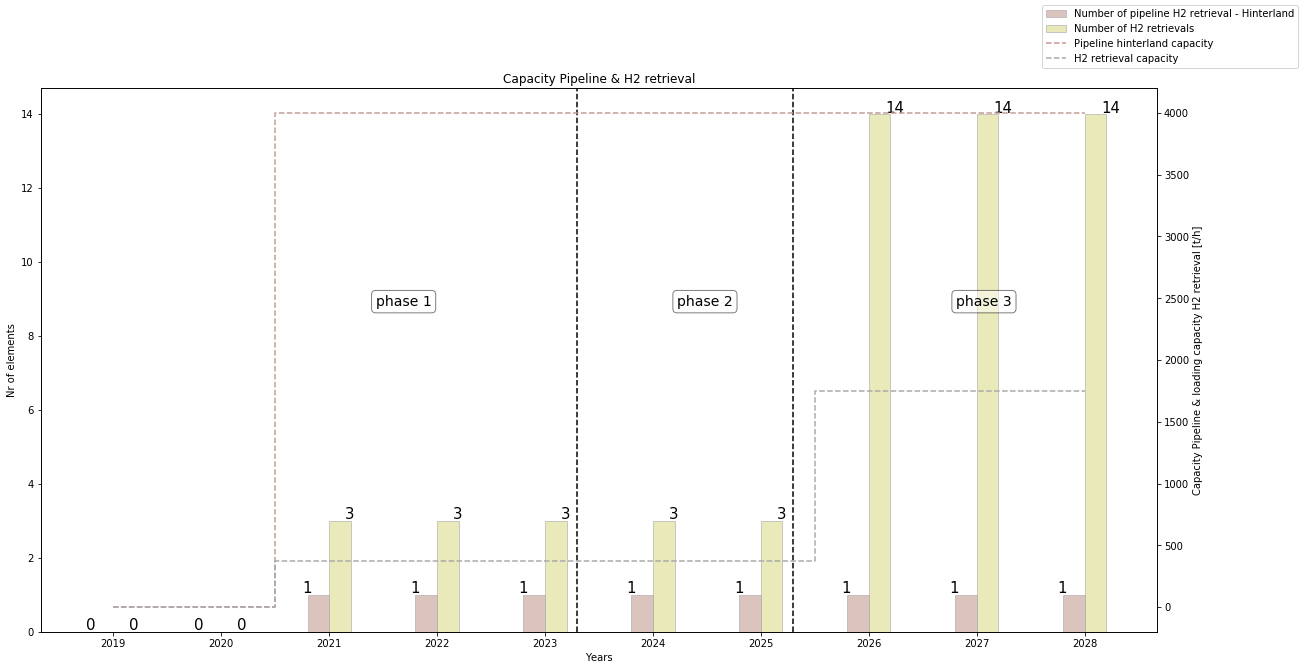

In [10]:
if True: 
    # to plot the terminal occupany's 
    Terminal.terminal_occupancy_plot() #occupancy of the berth 
    Terminal.plant_occupancy_plot() #occupancy of the plant
    Terminal.station_occupancy_plot() #occupancy of the loading station
    
    # to plot the capacities of the different elements 
    Terminal.Jetty_capacity_plot() #jetty
    Terminal.Pipeline1_capacity_plot() #pipeline from jetty to storage
    Terminal.Storage_capacity_plot() #storage
    Terminal.H2retrieval_capacity_plot() # H2 retrieval
    Terminal.Pipeline2_capacity_plot() #pipeline from H2 retrieval to hinterland        

In [11]:
# add cash flow information for each of the Terminal elements
cash_flows, cash_flows_WACC_real = Terminal.add_cashflow_elements()

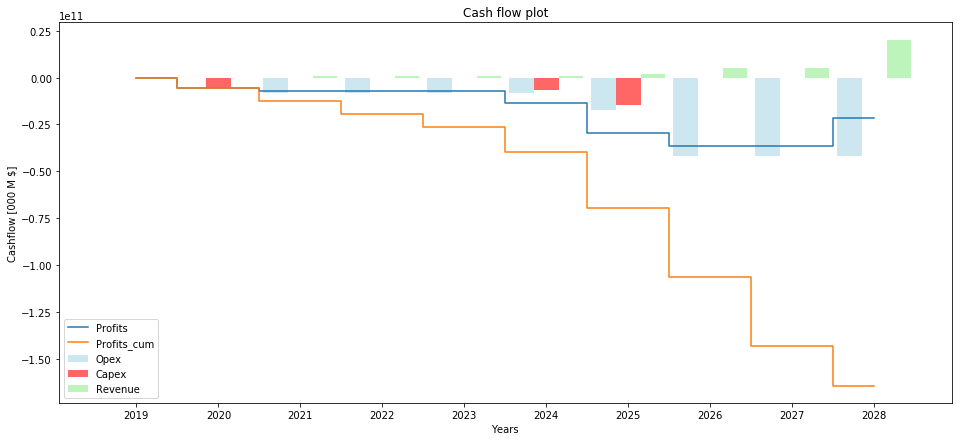

In [12]:
Terminal.cashflow_plot(cash_flows)

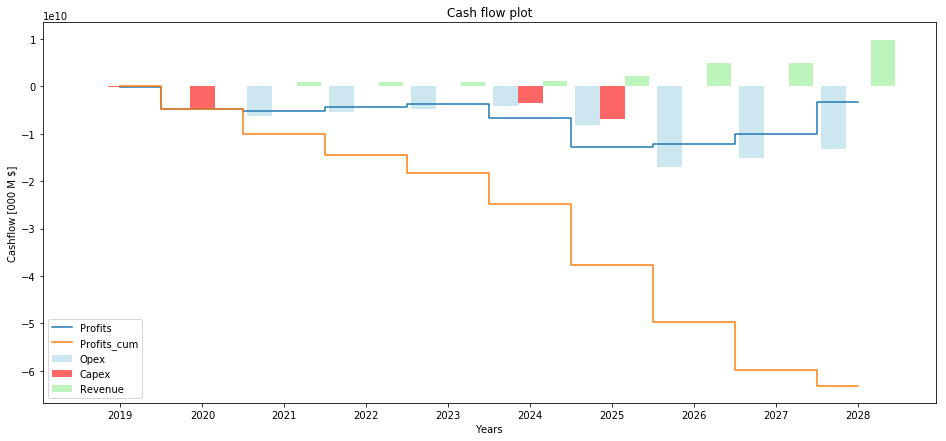

In [13]:
Terminal.cashflow_plot(cash_flows_WACC_real)